In [1]:
import os, sys
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OneHotEncoder,StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import RFE

from numpy import set_printoptions
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB



In [2]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [3]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from mlxtend.classifier import StackingClassifier
from kerastuner.tuners import RandomSearch
import numpy as np

In [4]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{exps_dir}/feature1/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0, 1: 1.0}

#### * Tinh chỉnh siêu tham số cho mô hình Support Vector Machine (SVM) bằng cách sử dụng RandomizedSearchCV:

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform

# Định nghĩa không gian siêu tham số
param_dist = {'C': uniform(0.1, 10),
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))}

# Khởi tạo mô hình SVM
svm_model = SVC()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist, n_iter=5, scoring='accuracy', cv=5)
random_search.fit(x_train, y_train)

# In ra thông tin của mô hình SVM tốt nhất
print("Best SVM Hyperparameters:")
print(random_search.best_params_)
C=random_search.best_params_['C']
gamma=random_search.best_params_['gamma']
kernel=random_search.best_params_['kernel']

Best SVM Hyperparameters:
{'C': 1.5864970953096202, 'gamma': 'scale', 'kernel': 'linear'}


#### * Tinh chỉnh siêu tham số cho mô hình Random Forest bằng cách sử dụng RandomizedSearchCV:

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Định nghĩa không gian siêu tham số
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20],
}

# Khởi tạo mô hình Random Forest
rf_model = RandomForestClassifier()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=5, scoring='accuracy', cv=5)
random_search_rf.fit(x_train, y_train)

# In ra thông tin của mô hình Random Forest tốt nhất
print("Best Random Forest Hyperparameters:")
print(random_search_rf.best_params_)
n_estimators=random_search_rf.best_params_['n_estimators']
max_depth=random_search_rf.best_params_['max_depth']


Best Random Forest Hyperparameters:
{'n_estimators': 400, 'max_depth': 15}


#### * Tinh chỉnh siêu tham số cho mô hình Gradient Boosting Classifier bằng cách sử dụng RandomizedSearchCV:

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform, randint

# Định nghĩa không gian siêu tham số cho Gradient Boosting
param_dist_gb = {'n_estimators': randint(50, 200),
                 'learning_rate': uniform(0.01, 0.1),
                 'max_depth': randint(3, 10),
                 'subsample': uniform(0.6, 0.4)}

# Khởi tạo mô hình Gradient Boosting
gb_model = GradientBoostingClassifier()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist_gb, n_iter=5, scoring='accuracy', cv=5)
random_search_gb.fit(x_train, y_train)

# In ra thông tin của mô hình Gradient Boosting tốt nhất
print("Best Gradient Boosting Hyperparameters:")
print(random_search_gb.best_params_)
best_gb_model = random_search_gb.best_estimator_
max_depthgb=random_search_gb.best_params_['max_depth']
learning_rate=random_search_gb.best_params_['learning_rate']
n_estimatorsgb=random_search_gb.best_params_['n_estimators']
subsample=random_search_gb.best_params_['subsample']

Best Gradient Boosting Hyperparameters:
{'learning_rate': 0.08315682484548642, 'max_depth': 6, 'n_estimators': 110, 'subsample': 0.8467828880975322}


#### * Tinh chỉnh siêu tham số cho mô hình Decision Tree Classifier bằng cách sử dụng RandomizedSearchCV:

In [8]:
from sklearn.tree import DecisionTreeClassifier

# Định nghĩa không gian siêu tham số cho Decision Tree
param_dist_dt = {'criterion': ['gini', 'entropy'],
                 'splitter': ['best', 'random'],
                 'max_depth': randint(3, 10),
                 'min_samples_split': randint(2, 20),
                 'min_samples_leaf': randint(1, 20)}

# Khởi tạo mô hình Decision Tree
dt_model = DecisionTreeClassifier()

# Sử dụng RandomizedSearchCV để tinh chỉnh siêu tham số
random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_dist_dt, n_iter=5, scoring='accuracy', cv=5)
random_search_dt.fit(x_train, y_train)

# In ra thông tin của mô hình Decision Tree tốt nhất
print("Best Decision Tree Hyperparameters:")
print(random_search_dt.best_params_)
best_dt_model = random_search_dt.best_estimator_
criterion=random_search_dt.best_params_['criterion']
max_depthdt=random_search_dt.best_params_['max_depth']
min_samples_leaf=random_search_dt.best_params_['min_samples_leaf']
splitter=random_search_dt.best_params_['splitter']
min_samples_split=random_search_dt.best_params_['min_samples_split']


Best Decision Tree Hyperparameters:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'splitter': 'best'}


In [9]:
x_test.shape

(330, 42)

In [10]:
x_train.shape

(1022, 42)

#### * Xây dựng model:

In [16]:
from tensorflow.keras.optimizers import Adam
lr=0.0001

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=2048, step=32),
                           activation='relu', input_dim=42))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=2048, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=2048, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_4', min_value=32, max_value=2048, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_5', min_value=32, max_value=2048, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# keras_clf = KerasClassifier(build_fn=create_keras_model, epochs=10)
rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
gb_model = SVC(C=C,kernel=kernel,gamma=gamma,probability=True)
dtc_model=DecisionTreeClassifier(criterion=criterion,max_depth=max_depthdt,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,splitter=splitter)
bg_model=GradientBoostingClassifier(n_estimators=n_estimatorsgb, learning_rate=learning_rate, max_depth=max_depthgb, subsample=subsample)
# Huấn luyện các mô hình cơ sở
rf_model.fit(x_train, y_train)
gb_model.fit(x_train, y_train)
dtc_model.fit(x_train, y_train)
bg_model.fit(x_train, y_train)


# Dự đoán đầu ra của các mô hình cơ sở
rf_pred = rf_model.predict(x_test)
gb_pred = gb_model.predict(x_test)
dtc_pred = dtc_model.predict(x_test)
bg_pred = bg_model.predict(x_test)


# keras_pred = keras_clf.predict(x_test)
stacked_input = np.column_stack((rf_pred,dtc_pred))
from tensorflow.keras.callbacks import Callback
class ConfusionMatrixCallback(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.relist={}
        self.acc=[]

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        y_pred_binary = (y_pred > 0.5).astype(int)

        cm = confusion_matrix(y_val, y_pred_binary)
        print(f"Confusion Matrix after Epoch {epoch + 1}:\n{cm}")
        print(classification_report(y_test,y_pred_binary))
        acc = float(classification_report(y_test,y_pred_binary).split('\n')[3].split()[2])
        self.acc.append(acc)
        self.relist[acc]=y_pred_binary

# ... Định nghĩa mô hình ...

# Tạo đối tượng callback
confusion_matrix_callback = ConfusionMatrixCallback(validation_data=(x_test,y_test))
# Tạo đối tượng RandomSearch tuner
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=5)

# Tìm kiếm tham số tốt nhất
tuner.search(x_train, y_train, epochs=120, validation_data=(x_test, y_test),callbacks=[confusion_matrix_callback])

# Lấy mô hình tốt nhất
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 5 Complete [00h 00m 58s]
val_accuracy: 0.6696969866752625

Best val_accuracy So Far: 0.7181817889213562
Total elapsed time: 00h 06m 02s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1888)              81184     
                                                                 
 batch_normalization (BatchN  (None, 1888)             7552      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1888)              0         
                                                                 
 dense_1 (Dense)             (None, 736)               1390304   
                                                                 
 batch_normalization_1 (Batc  (None, 736)              2944      
 hNormalization)                              

In [17]:
best_trials = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
best_trials

{'units_1': 1888, 'units_2': 736, 'units_3': 576, 'units_4': 64, 'units_5': 96}

#### * Xây dựng Stacked_model:

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.metrics import accuracy_score
import numpy as np
from tensorflow.keras.optimizers import Adam


# Hàm để xây dựng mô hình đầu ra
def model_output(unit1, unit2, unit3, unit4, unit5):
    lr=0.0001
    stacked_model = Sequential()
    stacked_model.add(Dense(unit1, activation='relu',input_dim=2))
    stacked_model.add(BatchNormalization())
    stacked_model.add(Dropout(0.5))

    # Thêm các lớp ẩn
    stacked_model.add(Dense(unit2, activation='relu'))
    stacked_model.add(BatchNormalization())
    stacked_model.add(Dropout(0.5))

    stacked_model.add(Dense(unit3, activation='relu'))
    stacked_model.add(BatchNormalization())
    stacked_model.add(Dropout(0.5))

    stacked_model.add(Dense(unit4, activation='relu'))
    stacked_model.add(BatchNormalization())
    stacked_model.add(Dropout(0.5))

    stacked_model.add(Dense(unit5, activation='relu'))
    stacked_model.add(BatchNormalization())
    stacked_model.add(Dropout(0.5))

    # Lớp đầu ra với activation function 'sigmoid' cho bài toán phân lớp nhị phân
    stacked_model.add(Dense(1, activation='sigmoid'))
    stacked_model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return stacked_model

# # Lấy các tham số tối ưu từ tuner
# best_trials = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

# # Xây dựng mô hình stacked với các tham số tối ưu
# stacked_model = model_output(best_trials['units_1'], best_trials['units_2'], best_trials['units_3'],
#                               best_trials['units_4'], best_trials['units_5'])
# stacked_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Huấn luyện mô hình stacked trên dữ liệu đầu ra của các mô hình cơ sở
# stacked_model.fit(stacked_input, y_test, epochs=50, batch_size=32, validation_split=0.2)

# # Dự đoán và đánh giá mô hình stacked
# binary_stacked_pred = stacked_model.predict(stacked_input)
# binary_stacked_pred = (binary_stacked_pred > 0.5).astype(int)

# # Sử dụng cú pháp trích xuất trên NumPy array
# accuracy_stacked = accuracy_score(y_test_array, binary_stacked_pred)
# print(f'Accuracy of Stacked Model: {accuracy_stacked}')


#### * Sử dụng Stacking để kết hợp dự đoán của các mô hình cơ sở để tạo ra một mô hình cuối cùng:

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier
import numpy as np
def create_keras_model():
    # Thêm các lớp khác vào đây
    best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return best_model

# keras_clf = KerasClassifier(build_fn=create_keras_model, epochs=10)
rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
gb_model = SVC(C=C,kernel=kernel,gamma=gamma,probability=True)
dtc_model=DecisionTreeClassifier(criterion=criterion,max_depth=max_depthdt,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,splitter=splitter)
bg_model=GradientBoostingClassifier(n_estimators=n_estimatorsgb, learning_rate=learning_rate, max_depth=max_depthgb, subsample=subsample)
# Huấn luyện các mô hình cơ sở
rf_model.fit(x_train, y_train)
gb_model.fit(x_train, y_train)
dtc_model.fit(x_train, y_train)
bg_model.fit(x_train, y_train)


# Dự đoán đầu ra của các mô hình cơ sở
rf_pred = rf_model.predict(x_test)
gb_pred = gb_model.predict(x_test)
dtc_pred = dtc_model.predict(x_test)
bg_pred = bg_model.predict(x_test)


# keras_pred = keras_clf.predict(x_test)
stacked_input = np.column_stack((rf_pred,dtc_pred))
class ConfusionMatrixCallback(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.relist={}
        self.acc=[]

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(stacked_input)
        y_pred_binary = (y_pred > 0.5).astype(int)

        cm = confusion_matrix(y_val, y_pred_binary)
        print(f"Confusion Matrix after Epoch {epoch + 1}:\n{cm}")
        print(classification_report(y_test,y_pred_binary))
        acc = float(classification_report(y_test,y_pred_binary).split('\n')[3].split()[2])
        self.acc.append(acc)
        self.relist[acc]=y_pred_binary

# ... Định nghĩa mô hình ...

# Tạo đối tượng callback
confusion_matrix_callback = ConfusionMatrixCallback(validation_data=(x_test,y_test))

#history=model.fit(x=x_train,y=y_train,
          #validation_data=(x_test,y_test),class_weight=class_weights_dict ,
          #batch_size=64,epochs=120, callbacks=[confusion_matrix_callback])

keras_clf = KerasClassifier(build_fn=model_output, unit1=best_trials['units_1'], unit2=best_trials['units_2'], unit3=best_trials['units_3'], unit4=best_trials['units_4'], unit5=best_trials['units_5'],batch_size=64,epochs=120,callbacks=[confusion_matrix_callback])

# Clone lại để tránh thay đổi trực tiếp vào mô hình gốc
keras_clf = clone(keras_clf)

# Xây dựng mô hình stacking
stacked_model = StackingClassifier(
    classifiers=[rf_model, dtc_model],
    meta_classifier=keras_clf
)

# Tiếp tục với việc huấn luyện và đánh giá mô hình stacking
stacked_model.fit(stacked_input, y_test)
stacked_pred = stacked_model.predict(stacked_input)
stacked_pred

Epoch 1/120
11/11 [==============================] - 0s 3ms/steps: 0.9031 - accuracy: 0.524
Confusion Matrix after Epoch 1:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       0.54      0.73      0.62       330

6/6 [==============================] - 2s 80ms/step - loss: 0.9031 - accuracy: 0.5242
Epoch 2/120
11/11 [==============================] - 0s 4ms/steps: 0.8506 - accuracy: 0.60
Confusion Matrix after Epoch 2:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       0.5

Epoch 16/120
11/11 [==============================] - 0s 2ms/steps: 0.7382 - accuracy: 0.69
Confusion Matrix after Epoch 16:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       0.54      0.73      0.62       330

6/6 [==============================] - 0s 40ms/step - loss: 0.7468 - accuracy: 0.6909
Epoch 17/120
11/11 [==============================] - 0s 4ms/steps: 0.6586 - accuracy: 0.74
Confusion Matrix after Epoch 17:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       

6/6 [==============================] - 0s 41ms/step - loss: 0.6998 - accuracy: 0.7788
Epoch 31/120
11/11 [==============================] - 0s 3ms/steps: 0.7708 - accuracy: 0.70
Confusion Matrix after Epoch 31:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       0.54      0.73      0.62       330

6/6 [==============================] - 0s 40ms/step - loss: 0.7708 - accuracy: 0.7091
Epoch 32/120
11/11 [==============================] - 0s 2ms/steps: 0.6910 - accuracy: 0.70
Confusion Matrix after Epoch 32:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.

Epoch 46/120
11/11 [==============================] - 0s 3ms/steps: 0.6736 - accuracy: 0.74
Confusion Matrix after Epoch 46:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       0.54      0.73      0.62       330

6/6 [==============================] - 0s 41ms/step - loss: 0.6786 - accuracy: 0.7364
Epoch 47/120
11/11 [==============================] - 0s 4ms/steps: 0.7616 - accuracy: 0.70
Confusion Matrix after Epoch 47:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       

Epoch 61/120
11/11 [==============================] - 0s 3ms/steps: 0.6804 - accuracy: 0.74
Confusion Matrix after Epoch 61:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       0.54      0.73      0.62       330

6/6 [==============================] - 0s 41ms/step - loss: 0.6804 - accuracy: 0.7455
Epoch 62/120
11/11 [==============================] - 0s 3ms/steps: 0.6738 - accuracy: 0.70
Confusion Matrix after Epoch 62:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       

6/6 [==============================] - 0s 40ms/step - loss: 0.6565 - accuracy: 0.7576
Epoch 76/120
11/11 [==============================] - 0s 3ms/steps: 0.5808 - accuracy: 0.75
Confusion Matrix after Epoch 76:
[[210  32]
 [ 37  51]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       242
           1       0.61      0.58      0.60        88

    accuracy                           0.79       330
   macro avg       0.73      0.72      0.73       330
weighted avg       0.79      0.79      0.79       330

6/6 [==============================] - 0s 40ms/step - loss: 0.6020 - accuracy: 0.7424
Epoch 77/120
11/11 [==============================] - 0s 3ms/steps: 0.5935 - accuracy: 0.74
Confusion Matrix after Epoch 77:
[[210  32]
 [ 37  51]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       242
           1       0.61      0.58      0.60        88

    accuracy                           0.

Epoch 91/120
11/11 [==============================] - 0s 3ms/steps: 0.8569 - accuracy: 0.76
Confusion Matrix after Epoch 91:
[[210  32]
 [ 37  51]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       242
           1       0.61      0.58      0.60        88

    accuracy                           0.79       330
   macro avg       0.73      0.72      0.73       330
weighted avg       0.79      0.79      0.79       330

6/6 [==============================] - 0s 40ms/step - loss: 0.6399 - accuracy: 0.7727
Epoch 92/120
11/11 [==============================] - 0s 4ms/steps: 0.6913 - accuracy: 0.76
Confusion Matrix after Epoch 92:
[[210  32]
 [ 37  51]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       242
           1       0.61      0.58      0.60        88

    accuracy                           0.79       330
   macro avg       0.73      0.72      0.73       330
weighted avg       

6/6 [==============================] - 0s 40ms/step - loss: 0.6686 - accuracy: 0.7485
Epoch 106/120
11/11 [==============================] - 0s 3ms/steps: 0.5992 - accuracy: 0.73
Confusion Matrix after Epoch 106:
[[210  32]
 [ 37  51]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       242
           1       0.61      0.58      0.60        88

    accuracy                           0.79       330
   macro avg       0.73      0.72      0.73       330
weighted avg       0.79      0.79      0.79       330

6/6 [==============================] - 0s 38ms/step - loss: 0.5796 - accuracy: 0.7636
Epoch 107/120
11/11 [==============================] - 0s 3ms/steps: 0.6394 - accuracy: 0.75
Confusion Matrix after Epoch 107:
[[210  32]
 [ 37  51]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       242
           1       0.61      0.58      0.60        88

    accuracy                         

11/11 [==============================] - 0s 3ms/step


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
    

In [23]:
print(keras_clf)

In [24]:
stacked_model.fit(stacked_input, y_test)
# Dự đoán và đánh giá mô hình stacked
stacked_pred = stacked_model.predict(stacked_input)
stacked_pred_binary = (stacked_pred > 0.5).astype(int)
accuracy_stacked = accuracy_score(y_test, stacked_pred_binary)
print(f'Accuracy of Stacked Model: {accuracy_stacked}')

Epoch 1/120
11/11 [==============================] - 0s 3ms/steps: 0.9838 - accuracy: 0.581
Confusion Matrix after Epoch 1:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       0.54      0.73      0.62       330

6/6 [==============================] - 3s 76ms/step - loss: 0.9838 - accuracy: 0.5818
Epoch 2/120
11/11 [==============================] - 0s 4ms/steps: 0.9168 - accuracy: 0.59
Confusion Matrix after Epoch 2:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       0.5

Epoch 16/120
11/11 [==============================] - 0s 4ms/steps: 0.7991 - accuracy: 0.67
Confusion Matrix after Epoch 16:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       0.54      0.73      0.62       330

6/6 [==============================] - 0s 40ms/step - loss: 0.7878 - accuracy: 0.6758
Epoch 17/120
11/11 [==============================] - 0s 4ms/steps: 0.7373 - accuracy: 0.68
Confusion Matrix after Epoch 17:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       

Epoch 31/120
11/11 [==============================] - 0s 3ms/steps: 0.7984 - accuracy: 0.70
Confusion Matrix after Epoch 31:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       0.54      0.73      0.62       330

6/6 [==============================] - 0s 39ms/step - loss: 0.7880 - accuracy: 0.7303
Epoch 32/120
11/11 [==============================] - 0s 3ms/steps: 0.6651 - accuracy: 0.76
Confusion Matrix after Epoch 32:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       

Epoch 46/120
11/11 [==============================] - 0s 3ms/steps: 0.7564 - accuracy: 0.72
Confusion Matrix after Epoch 46:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       0.54      0.73      0.62       330

6/6 [==============================] - 0s 41ms/step - loss: 0.7699 - accuracy: 0.7182
Epoch 47/120
11/11 [==============================] - 0s 3ms/steps: 0.7354 - accuracy: 0.77
Confusion Matrix after Epoch 47:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       

Epoch 61/120
11/11 [==============================] - 0s 3ms/steps: 0.6900 - accuracy: 0.72
Confusion Matrix after Epoch 61:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       0.54      0.73      0.62       330

6/6 [==============================] - 0s 40ms/step - loss: 0.6850 - accuracy: 0.7242
Epoch 62/120
11/11 [==============================] - 0s 3ms/steps: 0.7488 - accuracy: 0.71
Confusion Matrix after Epoch 62:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       

Epoch 76/120
11/11 [==============================] - 0s 2ms/steps: 0.6507 - accuracy: 0.75
Confusion Matrix after Epoch 76:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       0.54      0.73      0.62       330

6/6 [==============================] - 0s 41ms/step - loss: 0.6709 - accuracy: 0.7485
Epoch 77/120
11/11 [==============================] - 0s 4ms/steps: 0.6520 - accuracy: 0.74
Confusion Matrix after Epoch 77:
[[242   0]
 [ 88   0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       242
           1       0.00      0.00      0.00        88

    accuracy                           0.73       330
   macro avg       0.37      0.50      0.42       330
weighted avg       

Epoch 91/120
11/11 [==============================] - 0s 4ms/steps: 0.6278 - accuracy: 0.76
Confusion Matrix after Epoch 91:
[[210  32]
 [ 37  51]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       242
           1       0.61      0.58      0.60        88

    accuracy                           0.79       330
   macro avg       0.73      0.72      0.73       330
weighted avg       0.79      0.79      0.79       330

6/6 [==============================] - 0s 41ms/step - loss: 0.6289 - accuracy: 0.7727
Epoch 92/120
11/11 [==============================] - 0s 3ms/steps: 0.4767 - accuracy: 0.82
Confusion Matrix after Epoch 92:
[[210  32]
 [ 37  51]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       242
           1       0.61      0.58      0.60        88

    accuracy                           0.79       330
   macro avg       0.73      0.72      0.73       330
weighted avg       

6/6 [==============================] - 0s 40ms/step - loss: 0.5880 - accuracy: 0.7848
Epoch 106/120
11/11 [==============================] - 0s 3ms/steps: 0.4422 - accuracy: 0.84
Confusion Matrix after Epoch 106:
[[210  32]
 [ 37  51]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       242
           1       0.61      0.58      0.60        88

    accuracy                           0.79       330
   macro avg       0.73      0.72      0.73       330
weighted avg       0.79      0.79      0.79       330

6/6 [==============================] - 0s 38ms/step - loss: 0.5605 - accuracy: 0.7636
Epoch 107/120
11/11 [==============================] - 0s 3ms/steps: 0.6182 - accuracy: 0.77
Confusion Matrix after Epoch 107:
[[210  32]
 [ 37  51]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       242
           1       0.61      0.58      0.60        88

    accuracy                         

11/11 [==============================] - 0s 3ms/step
Accuracy of Stacked Model: 0.8333333333333334


#### * Kết quả đánh giá mô hình:

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, stacked_pred)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, stacked_pred,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.8333333333333334
Classification Report:
              precision    recall  f1-score   support

           1       0.66      0.78      0.72        88
           0       0.92      0.85      0.88       242

    accuracy                           0.83       330
   macro avg       0.79      0.82      0.80       330
weighted avg       0.85      0.83      0.84       330



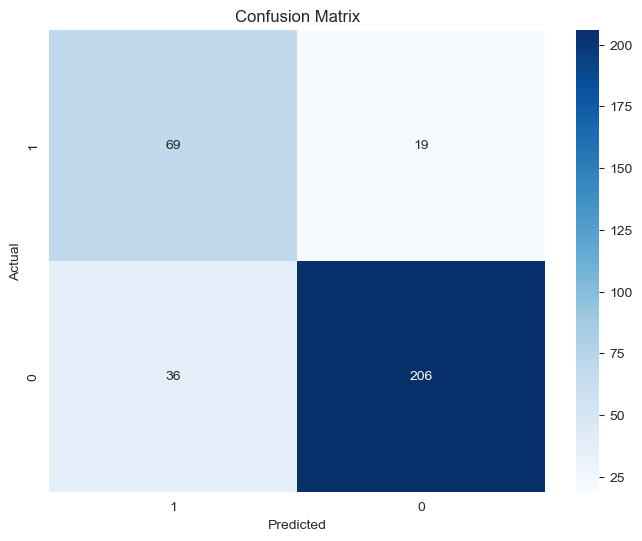

In [26]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, stacked_pred,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [27]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [28]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = stacked_model.predict(stacked_input)
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N

11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 4ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 4ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 4ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 4ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N

11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 4ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 4ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: Y

11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 4ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 4ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 4ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 4ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 4ms/step
True: N
Predicted: N

11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: Y
----------------------------
11/11 [==============================] - 0s 4ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 4ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: Y
Predicted: Y
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 3ms/step
True: N
Predicted: N
----------------------------
11/11 [==============================] - 0s 4ms/step
True: N
Predicted: N

In [29]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 275 chiếm khoảng 83.33333333333334% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 69 chiếm khoảng 78.4090909090909% so với thực tế
